In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[: 8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)
vocab_size = len(stoi)
vocab_size

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


27

In [4]:
#build dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]  * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out))
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim) #gain
        self.beta = torch.zeros(dim) #bias
        
        #buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True) #batch mean
            xvar = x.var(0, keepdim = True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma*xhat + self.beta
            
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1 - self.momentum)*self.running_var + self.momentum*xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []       

In [6]:
torch.manual_seed(42)

In [7]:
n_embd = 10 #character embedding dimensionality
n_hidden = 200 #number of neurons in hidden layer of MLP

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), 
]

with torch.no_grad():
    layers[-1].weight *= 0.01 #make the last layer less confident for first pass, more equal distribution of probability

parameters = [C] + [p for layer in layers for p in layer.parameters()]    
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [8]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function

    #backward pass
    for layer in layers:
        layer.out.retain_grad() #take out after debug
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 1.0 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000:3.2982
  10000/ 200000:2.3611
  20000/ 200000:2.6819
  30000/ 200000:2.1526
  40000/ 200000:2.3833
  50000/ 200000:2.6643
  60000/ 200000:2.2454
  70000/ 200000:2.1003
  80000/ 200000:2.9674
  90000/ 200000:2.2589
 100000/ 200000:2.3329
 110000/ 200000:1.8038
 120000/ 200000:2.3516
 130000/ 200000:2.4061
 140000/ 200000:2.2388
 150000/ 200000:2.0495
 160000/ 200000:2.1254
 170000/ 200000:2.3981
 180000/ 200000:2.0209
 190000/ 200000:2.2488


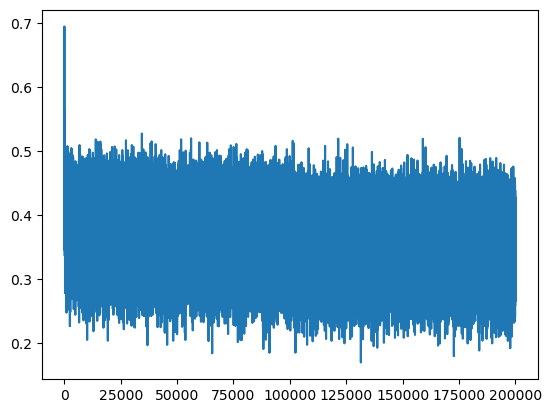

In [9]:
#loss fluctuating too much from run to run -> mini batch size needs to be increased
plt.plot(lossi)

In [10]:
#put layers into eval mode
for layer in layers:
    layer.training = False

In [11]:
@torch.no_grad()  #disables gradient tracking
def split_loss(split):
    x, y = {'train': (Xtr, Ytr), 
            'val': (Xdev, Ydev), 
            'test': (Xte, Yte)}[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2333083152770996
val 2.235912799835205


In [12]:
#sample from the model
g = torch.Generator().manual_seed(9034568)
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

damiar.
karkona.
fhetti.
gerw.
sayah.
ayvo.
rein.
jastielle.
caqineian.
zalitntyn.
